In [1]:
import numpy as np
import pandas as pd
import os
import torchvision as tv
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
random.seed(6)
np.random.seed(6)
torch.manual_seed(6)
torch.cuda.manual_seed(6)
torch.backends.cudnn.deterministic = True
data_root = './copters/copters/'
train_dir = data_root + 'train'
val_dir = data_root + 'test'
test_dir = './copters/test'

In [3]:
class_names = ['planes', 'rotors']

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [5]:
class ImageFolderWithPaths(tv.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
def show_input(input_tensor, title=''):
    if type(input_tensor) != 'numpy.ndarray':
        input_tensor = input_tensor.numpy()
    image = input_tensor.transpose(1, 2, 0)
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

In [7]:
class PlanesCoptersNet(torch.nn.Module):
    def __init__(self, train_dataloader, val_dataloader, epoch_size=50):
        super(PlanesCoptersNet, self).__init__()
        self._submodel = tv.models.resnet18(pretrained=True)
        for param in self._submodel.parameters():
            # param.
            param.requires_grad = False
        self._submodel.fc = torch.nn.Linear(self._submodel.fc.in_features, self._submodel.fc.out_features)
        self._device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self._fc1 = torch.nn.Linear(in_features=1000, out_features=50)
        self._fc2 = torch.nn.Linear(in_features=50, out_features=2)
        # self._fc3 = torch.nn.Linear(in_features=10, out_features=2)
        self._relu = torch.nn.LeakyReLU(inplace=True)
        self._train(train_dataloader, val_dataloader, epoch_size)
            
    def _forward(self, x):
        x = self._submodel(x)
        x = self._relu(x)
        x = self._fc1(x)
        x = self._relu(x)
        x = self._fc2(x)
        # x = self._relu(x)
        # x = self._fc3(x)
        return x
    
    def _train(self, train_dataloader, val_dataloader, epoch_size):
        statistics = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
        }
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1.0e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        self = self.to(self._device)
        self.train()
        
        for epoch in range(epoch_size):
            print('Epoch {}/{}:'.format(epoch+1, epoch_size), flush=True)
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train_dataloader
                    scheduler.step()
                    self.train()
                else:
                    dataloader = val_dataloader
                    self.eval()
                running_loss = 0.
                running_acc = 0.
                
                for inputs, labels in tqdm(dataloader):
                    step_size=7
                    inputs = inputs.to(self._device)
                    labels = labels.to(self._device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = self._forward(inputs)
                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()
                    # statistics
                    running_loss += loss_value.item()
                    running_acc += (preds_class == labels.data).float().mean()
                
                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)
                if phase == 'train':
                    statistics['train_loss'].append(epoch_loss)
                    statistics['train_acc'].append(epoch_acc.item())
                else:
                    statistics['val_loss'].append(epoch_loss)
                    statistics['val_acc'].append(epoch_acc.item())
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc),
                flush=True)
            print()
        
        self.eval()
        statistics = pd.DataFrame(statistics)
        statistics.plot(y=['val_loss', 'train_loss'])
        plt.show()
        
    def predict(self, dataloader):
        test_predictions = []
        test_img_paths = []
        for inputs, labels, paths in tqdm(dataloader):
            inputs = inputs.to(self._device)
            labels = labels.to(self._device)
            with torch.set_grad_enabled(False):
                preds = self._forward(inputs)
            # test_predictions.append(preds.argmax(dim=1).data.cpu().numpy()
            test_predictions = np.append(test_predictions, preds.argmax(dim=1).data.cpu().numpy())
            # torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
            #)
            test_img_paths.extend(paths)
            # print(test_predictions)
            # test_predictions = np.concatenate(test_predictions)
        # if need_show_input:
        # for img, pred in zip(test_inputs, test_predictions):
        # show_input(img, title=pred)
        test_predictions = test_predictions.astype('int32')
        return test_img_paths, test_predictions

In [8]:
train_transform = tv.transforms.Compose([
tv.transforms.RandomApply([
tv.transforms.ColorJitter(
brightness=0.5,
contrast=0.5,
saturation=0.5,
hue=0.5
)
]),
tv.transforms.RandomVerticalFlip(p=0.5),
tv.transforms.CenterCrop(884),
tv.transforms.RandomHorizontalFlip(),
tv.transforms.ToTensor(),
tv.transforms.Normalize(mean, std)
])
val_transforms = tv.transforms.Compose([
#tv.transforms.Resize((884, 884)),
tv.transforms.Resize((250, 250)),
tv.transforms.ToTensor(),
tv.transforms.Normalize(mean, std)
])
train_dataset = torch.utils.data.ConcatDataset([
# tv.datasets.ImageFolder(train_dir, train_transform),
# tv.datasets.ImageFolder(train_dir, train_transform),
# tv.datasets.ImageFolder(train_dir, train_transform),
# tv.datasets.ImageFolder(train_dir, train_transform),
# tv.datasets.ImageFolder(train_dir, train_transform),
tv.datasets.ImageFolder(train_dir, train_transform),
tv.datasets.ImageFolder(train_dir, train_transform),
tv.datasets.ImageFolder(train_dir, train_transform)
])
val_dataset = tv.datasets.ImageFolder(val_dir, val_transforms)

In [9]:
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [10]:
print("train tensor lenght: {}".format(len(train_dataloader)))
print("validation tensor lenght: {}".format(len(val_dataloader)))

train tensor lenght: 66
validation tensor lenght: 3


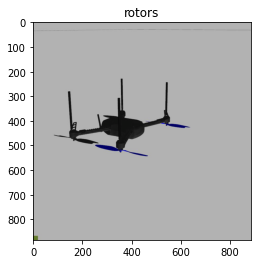

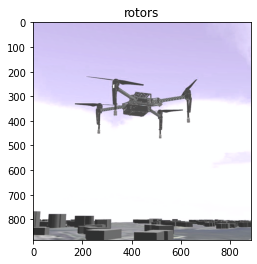

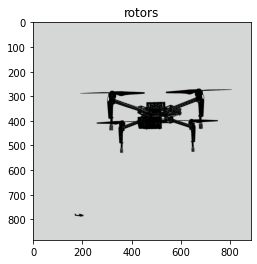

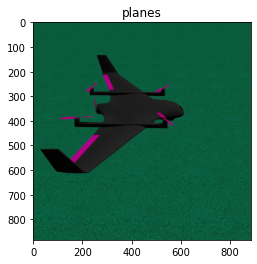

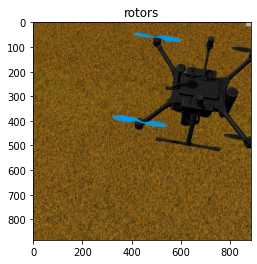

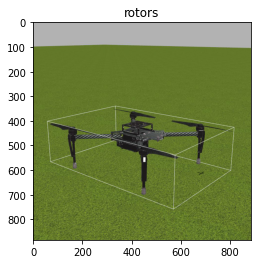

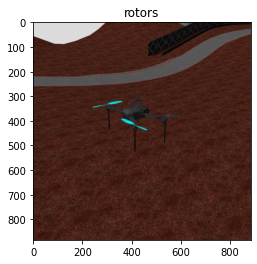

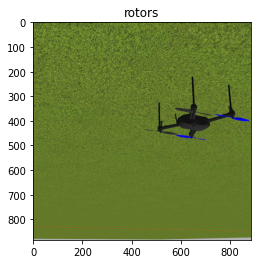

In [11]:
if True:
    X_batch, y_batch = next(iter(train_dataloader))
    for x_item, y_item in zip(X_batch, y_batch):
        show_input(x_item, title=class_names[y_item])

Epoch 1/50:


/home/deadln/programming/cnn/mlearn/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|                                                    | 0/66 [00:00<?, ?it/s]/home/deadln/programming/cnn/mlearn/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  r

train Loss: 0.6600 Acc: 0.6288



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]

val Loss: 0.6302 Acc: 0.6250

Epoch 2/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.27it/s]

train Loss: 0.6262 Acc: 0.6553



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]

val Loss: 0.5804 Acc: 0.6667

Epoch 3/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.26it/s]

train Loss: 0.6024 Acc: 0.6742



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]

val Loss: 0.9825 Acc: 0.6250

Epoch 4/50:



100%|███████████████████████████████████████████| 66/66 [00:19<00:00,  3.34it/s]

train Loss: 0.5611 Acc: 0.6856



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]

val Loss: 0.8157 Acc: 0.6250

Epoch 5/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.14it/s]

train Loss: 0.5689 Acc: 0.7292



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]

val Loss: 0.3529 Acc: 0.8750

Epoch 6/50:



100%|███████████████████████████████████████████| 66/66 [00:22<00:00,  2.93it/s]


train Loss: 0.4920 Acc: 0.7633


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]

val Loss: 0.4797 Acc: 0.8333

Epoch 7/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.25it/s]

train Loss: 0.4098 Acc: 0.7955



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]

val Loss: 0.4406 Acc: 0.8333

Epoch 8/50:



100%|███████████████████████████████████████████| 66/66 [00:19<00:00,  3.37it/s]

train Loss: 0.3954 Acc: 0.8239



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]

val Loss: 0.5293 Acc: 0.8333

Epoch 9/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.21it/s]

train Loss: 0.3811 Acc: 0.8201



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]

val Loss: 0.5170 Acc: 0.8333

Epoch 10/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.14it/s]

train Loss: 0.3947 Acc: 0.8182



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]

val Loss: 0.4503 Acc: 0.8333

Epoch 11/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.12it/s]

train Loss: 0.3963 Acc: 0.8314



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]

val Loss: 0.5842 Acc: 0.8333

Epoch 12/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.18it/s]

train Loss: 0.3549 Acc: 0.8561



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]

val Loss: 0.4528 Acc: 0.8333

Epoch 13/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.05it/s]

train Loss: 0.3782 Acc: 0.8352



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]

val Loss: 0.6744 Acc: 0.8333

Epoch 14/50:



100%|███████████████████████████████████████████| 66/66 [00:22<00:00,  2.96it/s]

train Loss: 0.3324 Acc: 0.8617



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]

val Loss: 0.6390 Acc: 0.8333

Epoch 15/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.03it/s]

train Loss: 0.3516 Acc: 0.8580



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]

val Loss: 0.5111 Acc: 0.8333

Epoch 16/50:



100%|███████████████████████████████████████████| 66/66 [00:22<00:00,  2.88it/s]

train Loss: 0.3821 Acc: 0.8201



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]

val Loss: 0.7268 Acc: 0.7917

Epoch 17/50:



100%|███████████████████████████████████████████| 66/66 [00:22<00:00,  2.94it/s]

train Loss: 0.3455 Acc: 0.8485



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]

val Loss: 0.5008 Acc: 0.8333

Epoch 18/50:



100%|███████████████████████████████████████████| 66/66 [00:22<00:00,  2.93it/s]

train Loss: 0.3570 Acc: 0.8390



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]

val Loss: 0.4986 Acc: 0.8333

Epoch 19/50:



100%|███████████████████████████████████████████| 66/66 [00:22<00:00,  2.96it/s]

train Loss: 0.3462 Acc: 0.8561



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


val Loss: 0.5011 Acc: 0.8333

Epoch 20/50:


100%|███████████████████████████████████████████| 66/66 [00:22<00:00,  2.87it/s]

train Loss: 0.3052 Acc: 0.8731



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]

val Loss: 0.6177 Acc: 0.8333

Epoch 21/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.03it/s]

train Loss: 0.3431 Acc: 0.8390



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]

val Loss: 0.6399 Acc: 0.8333

Epoch 22/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.11it/s]

train Loss: 0.3395 Acc: 0.8409



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]

val Loss: 0.4517 Acc: 0.8333

Epoch 23/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.12it/s]

train Loss: 0.3357 Acc: 0.8674



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]

val Loss: 0.4774 Acc: 0.8333

Epoch 24/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.19it/s]

train Loss: 0.3700 Acc: 0.8352



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]

val Loss: 0.4150 Acc: 0.8333

Epoch 25/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.20it/s]

train Loss: 0.3175 Acc: 0.8655



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]

val Loss: 0.5973 Acc: 0.8333

Epoch 26/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.09it/s]

train Loss: 0.3283 Acc: 0.8598



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]

val Loss: 0.6347 Acc: 0.8333

Epoch 27/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.10it/s]

train Loss: 0.3633 Acc: 0.8333



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]

val Loss: 0.6208 Acc: 0.8333

Epoch 28/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.16it/s]

train Loss: 0.3593 Acc: 0.8371



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]

val Loss: 0.4830 Acc: 0.8333

Epoch 29/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.06it/s]

train Loss: 0.3472 Acc: 0.8277



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]

val Loss: 0.5436 Acc: 0.8333

Epoch 30/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.13it/s]

train Loss: 0.3443 Acc: 0.8617



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]

val Loss: 0.3853 Acc: 0.8333

Epoch 31/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.10it/s]

train Loss: 0.3729 Acc: 0.8352



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]

val Loss: 0.4514 Acc: 0.8333

Epoch 32/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.16it/s]

train Loss: 0.3389 Acc: 0.8561



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]

val Loss: 0.3711 Acc: 0.8750

Epoch 33/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.16it/s]

train Loss: 0.3200 Acc: 0.8712



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]

val Loss: 0.5143 Acc: 0.8333

Epoch 34/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.14it/s]


train Loss: 0.3537 Acc: 0.8485


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]

val Loss: 0.6763 Acc: 0.8333

Epoch 35/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.25it/s]

train Loss: 0.3499 Acc: 0.8390



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]

val Loss: 0.6073 Acc: 0.8333

Epoch 36/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.28it/s]

train Loss: 0.3592 Acc: 0.8371



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]

val Loss: 0.5549 Acc: 0.8333

Epoch 37/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.14it/s]

train Loss: 0.3679 Acc: 0.8523



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]

val Loss: 0.4151 Acc: 0.8333

Epoch 38/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.06it/s]

train Loss: 0.3567 Acc: 0.8390



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.47it/s]

val Loss: 0.5242 Acc: 0.8333

Epoch 39/50:



100%|███████████████████████████████████████████| 66/66 [00:22<00:00,  2.96it/s]

train Loss: 0.3672 Acc: 0.8314



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]

val Loss: 0.7617 Acc: 0.8333

Epoch 40/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.10it/s]

train Loss: 0.3407 Acc: 0.8598



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]

val Loss: 0.4818 Acc: 0.8333

Epoch 41/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.16it/s]

train Loss: 0.3549 Acc: 0.8466



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]

val Loss: 0.5873 Acc: 0.8333

Epoch 42/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.15it/s]

train Loss: 0.3248 Acc: 0.8598



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]

val Loss: 0.4331 Acc: 0.8333

Epoch 43/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.20it/s]

train Loss: 0.3591 Acc: 0.8447



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]

val Loss: 0.4902 Acc: 0.8333

Epoch 44/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.24it/s]

train Loss: 0.3492 Acc: 0.8428



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]

val Loss: 0.5130 Acc: 0.8333

Epoch 45/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.20it/s]

train Loss: 0.3542 Acc: 0.8371



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]

val Loss: 0.5383 Acc: 0.8333

Epoch 46/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.21it/s]

train Loss: 0.3475 Acc: 0.8409



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]

val Loss: 0.3592 Acc: 0.8750

Epoch 47/50:



100%|███████████████████████████████████████████| 66/66 [00:21<00:00,  3.12it/s]

train Loss: 0.3394 Acc: 0.8485



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]

val Loss: 0.4978 Acc: 0.8333

Epoch 48/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.20it/s]

train Loss: 0.3460 Acc: 0.8523



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]

val Loss: 0.6423 Acc: 0.8333

Epoch 49/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.15it/s]

train Loss: 0.3469 Acc: 0.8295



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]

val Loss: 0.5488 Acc: 0.8333

Epoch 50/50:



100%|███████████████████████████████████████████| 66/66 [00:20<00:00,  3.22it/s]

train Loss: 0.3205 Acc: 0.8674



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]

val Loss: 0.5264 Acc: 0.8333


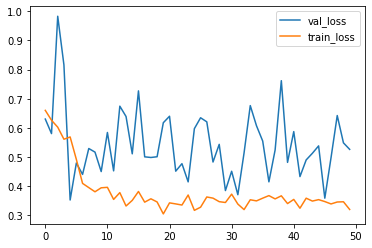

In [12]:
my_net2 = PlanesCoptersNet(train_dataloader, val_dataloader, epoch_size=50)

In [13]:
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  9.86it/s]


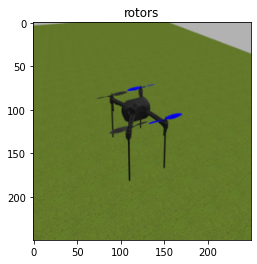

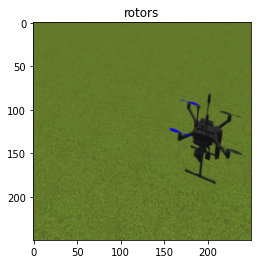

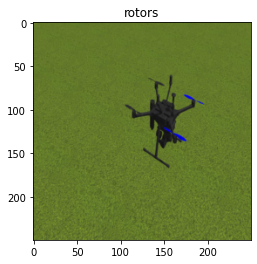

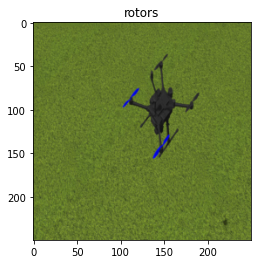

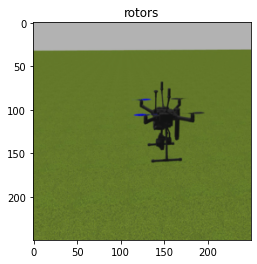

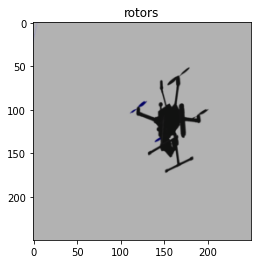

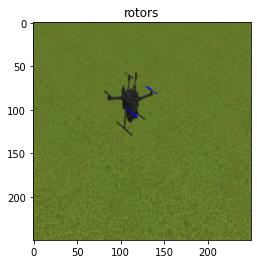

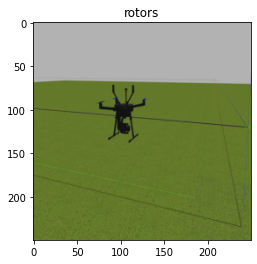

In [14]:
test_img_paths, test_predictions = my_net2.predict(test_dataloader)
if True:
    inputs, labels, paths = next(iter(test_dataloader))
    for img, pred in zip(inputs, map(lambda x: class_names[x], test_predictions)):
        show_input(img, title=pred)